In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal

import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable
import math

/home/nutapolt/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from common import EEG_fif

In [35]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = ''
base_url = 'https://physionet.org/files/eegmmidb/'
# subjects = [1]
#runs = [3, 4, 7, 8, 11, 12]
runs = [3,5,7]
subjects = [i for i in range(6,7)]
#subjects = [1]
#runs = [6,10,14]
print(path)
eeg = EEG_fif(path, base_url, subjects, runs)
raw=eeg.data_to_raw()

print("Raw done")
# apply filter
freq = (1., 45.)


raw=raw.notch_filter(np.arange(50, 125, 50))

print("Filter done")
#raw=eeg.raw_ica()


/home/nutapolt/eeg_mi/common.py:470: RuntimeWarning: This filename (S006/S006R03.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/home/nutapolt/eeg_mi/common.py:470: RuntimeWarning: This filename (S006/S006R05.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/home/nutapolt/eeg_mi/common.py:470: RuntimeWarning: This filename (S006/S006R07.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fi

Raw done
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filter done


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


In [36]:

raw=raw.filter( 7,30, method='fir', verbose=20)


#raw=raw.filter(8., 14, fir_design='firwin', verbose=20)
#raw=raw.apply_hilbert()
#raw=eeg.filter(freq=freq)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


In [37]:
epochs=eeg.epochs_visu(raw,tmin=-2)

180 events found
Event IDs: [1 2 4]
Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 90 events and 1501 original time points ...
3 bad epochs dropped


/home/nutapolt/eeg_mi/common.py:500: RuntimeWarning: No matching events found for 3 (event id 3)
  epochs = mne.Epochs(


In [38]:
raw.ch_names

['C3', 'C4', 'STIM MARKERS']

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


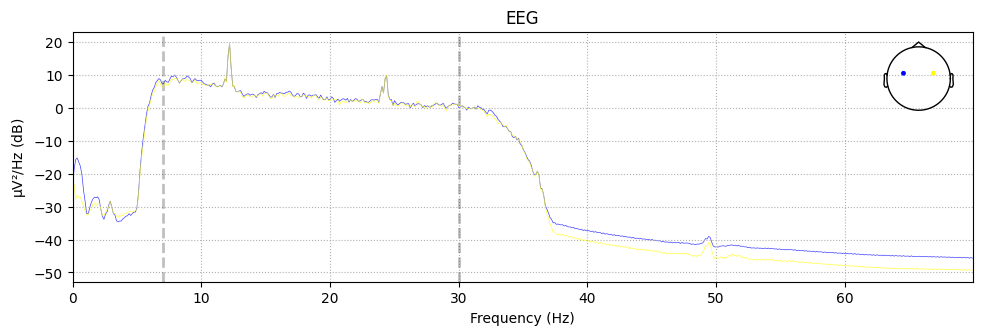

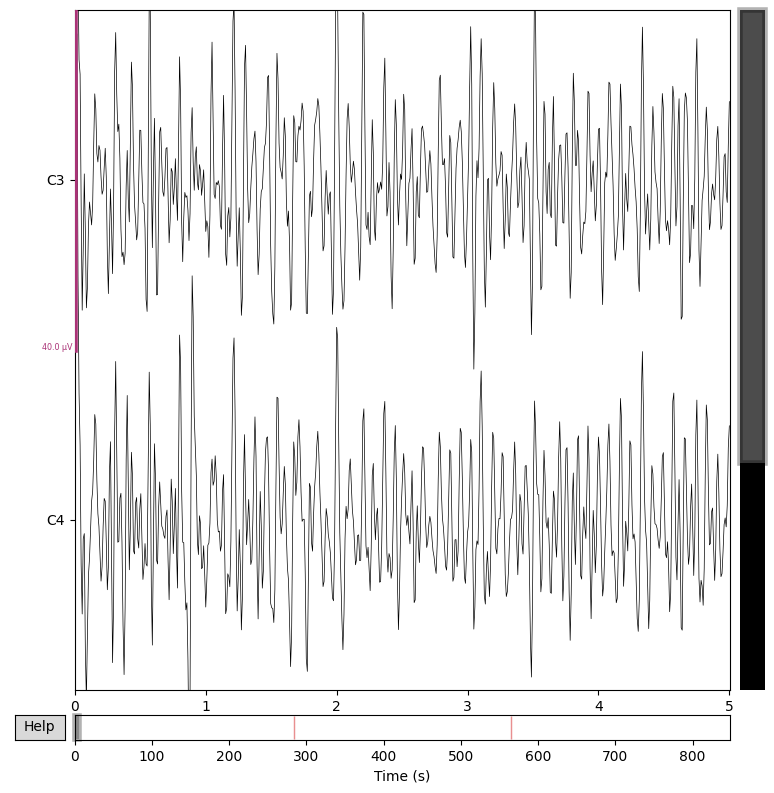

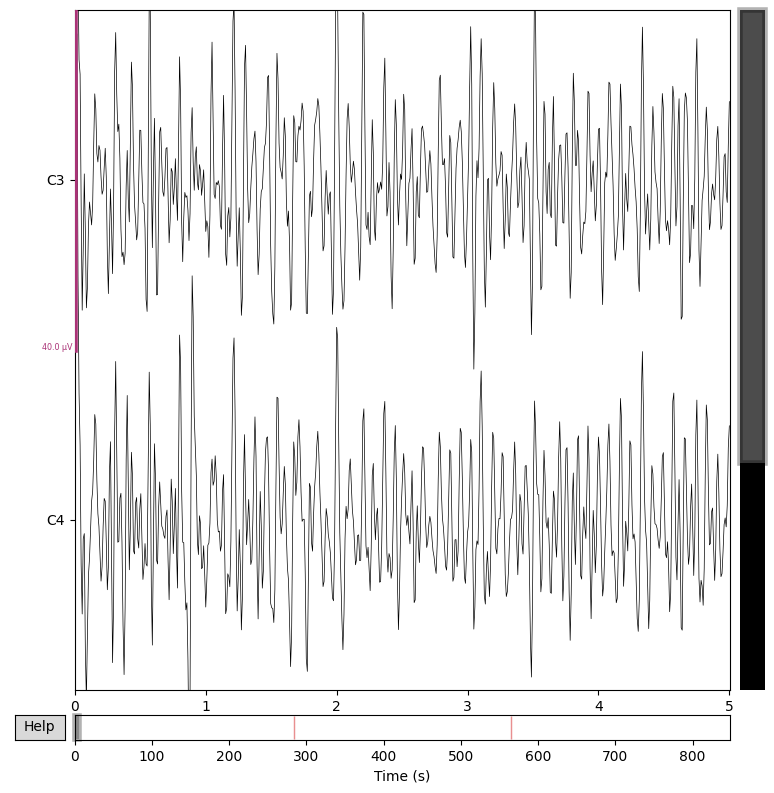

In [39]:
raw.plot_psd(fmax=70)
raw.plot(duration=5, n_channels=2)

In [40]:
epochs

Number of events,87
Events,1: 422: 453: 0
Time range,-2.000 – 4.000 sec
Baseline,-1.000 – 0.000 sec


In [41]:
epochs.event_id = {'Left': 1, 'Right': 2, '3': 3}
epochs.event_id

{'Left': 1, 'Right': 2, '3': 3}

In [42]:
l_vis_T1=epochs["Left"].average()
l_vis_T2=epochs["Right"].average()

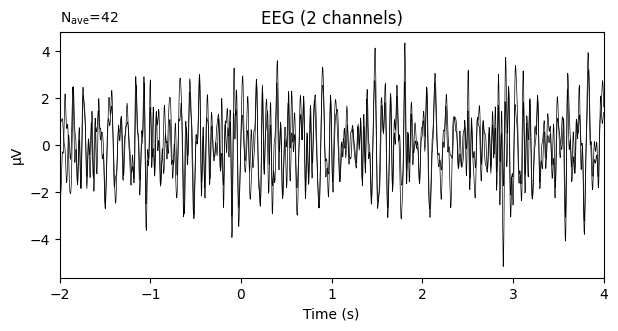

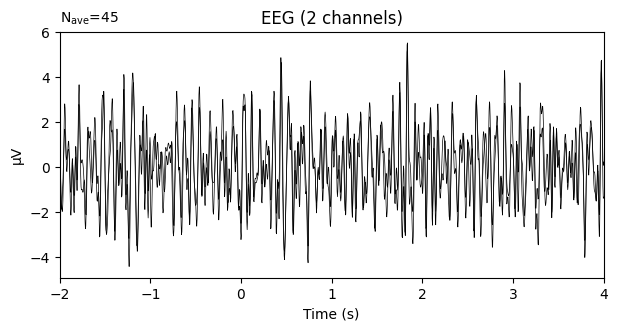

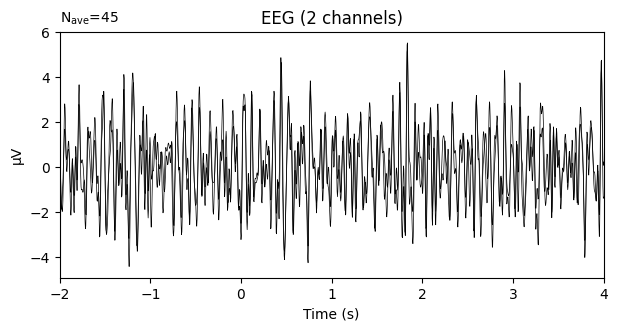

In [43]:
#l_vis_T1.plot(spatial_colors=True)
#l_vis_T2.plot(spatial_colors=True)


l_vis_T1.plot()
l_vis_T2.plot() 

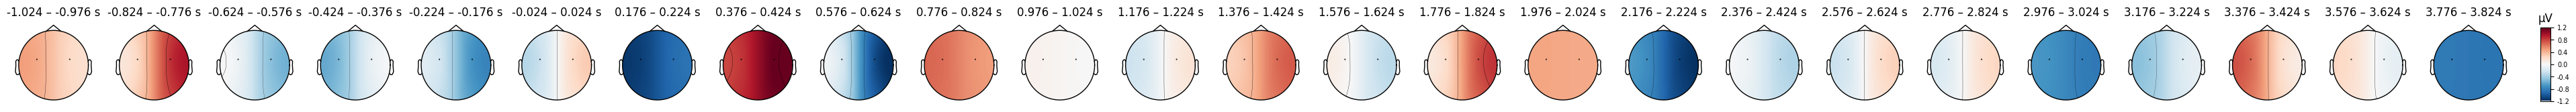

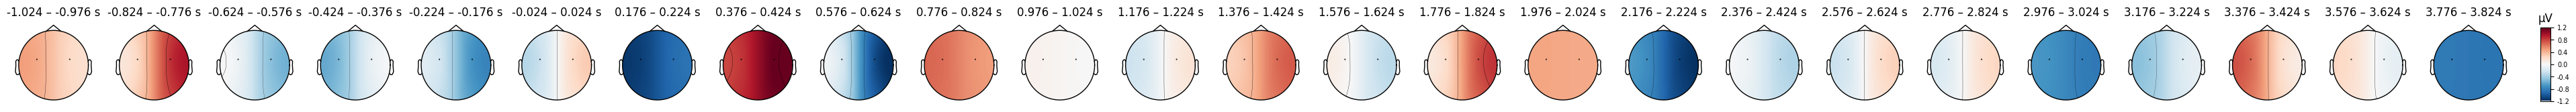

In [44]:
l_vis_T1.plot_topomap(times=list(np.arange(-1, 4, 0.20)), average=0.05, ch_type="eeg")

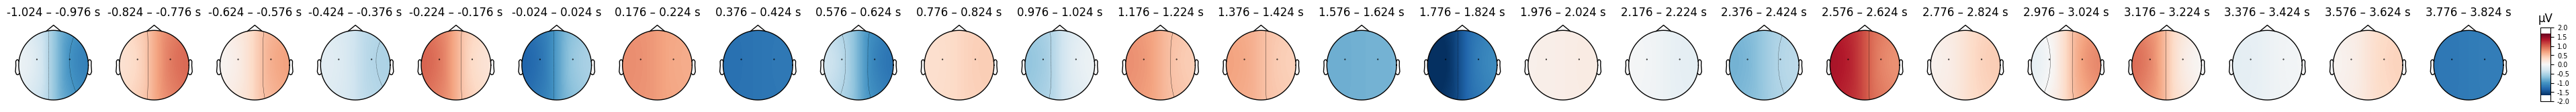

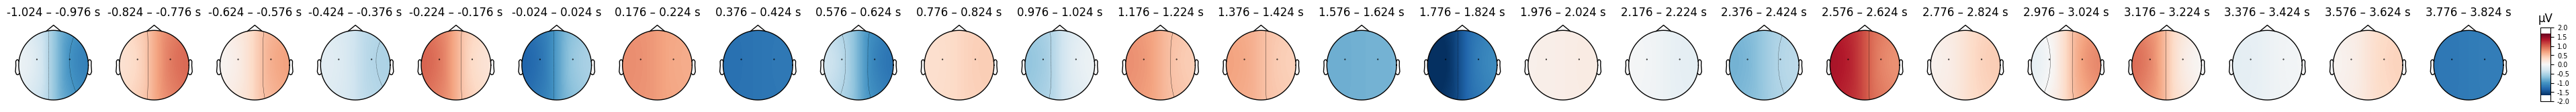

In [45]:
l_vis_T2.plot_topomap(times=list(np.arange(-1, 4, 0.20)), average=0.05, ch_type="eeg")

In [46]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

In [47]:
epochs

Number of events,87
Events,3: 0Left: 42Right: 45
Time range,-2.000 – 4.000 sec
Baseline,-1.000 – 0.000 sec


In [48]:
epochs_train = epochs.copy().crop(tmin=0., tmax=4.)
labels = epochs.events[:, -1] - 1

In [49]:
labels

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 2 dim * 2.4e+09  max singular value)
    Estimated rank (mag): 2
    MAG: rank 2 computed from 2 data channels with 0 projectors
Reducing data rank from 2 -> 2
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3e-07 (2.2e-16 eps * 2 dim * 2.1e+09  max singular value)
    Estimated rank (mag): 2
    MAG: rank 2 computed from 2 data channels with 0 projectors
Reducing data rank from 2 -> 2
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.7e-07 (2.2e-16 eps * 2 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 2
    MAG: rank 2 computed from 2 data channels with 0 projectors
Reducing data rank from 2 -> 2
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1e-06 (2.2e-16 eps * 2 dim * 2.3e+09  max singular value)
    Estimated rank (m

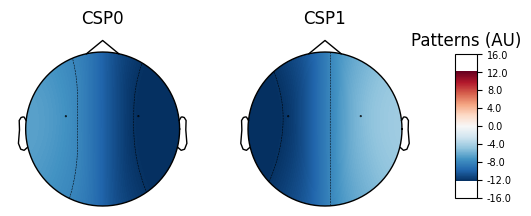

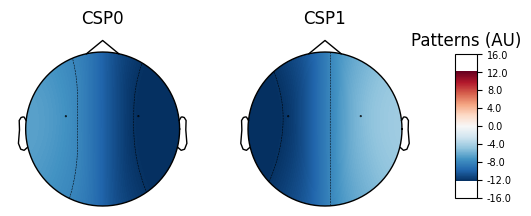

In [50]:
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.3, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=2, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 2 dim * 2.4e+09  max singular value)
    Estimated rank (mag): 2
    MAG: rank 2 computed from 2 data channels with 0 projectors
Reducing data rank from 2 -> 2
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3e-07 (2.2e-16 eps * 2 dim * 2.1e+09  max singular value)
    Estimated rank (mag): 2
    MAG: rank 2 computed from 2 data channels with 0 projectors
Reducing data rank from 2 -> 2
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.7e-07 (2.2e-16 eps * 2 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 2
    MAG: rank 2 computed from 2 data channels with 0 projectors
Reducing data rank from 2 -> 2
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1e-06 (2.2e-16 eps * 2 dim * 2.3e+09  max singular value)
    Estimated rank (m

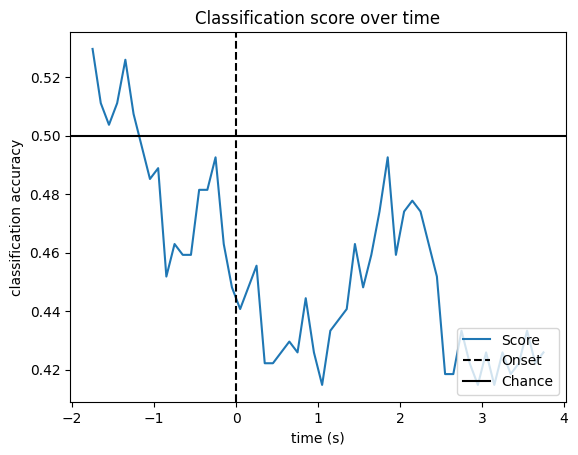

In [51]:
sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()